# Impact of bias errors on a maneuver

Investigate how a particular bias error affects the maneuver error.  This relies heavily on the 
[inject_errors](https://github.com/sot/Chandra.Maneuver/blob/80aaf21cf9dbc5939f967a7559b410b5aae00559/Chandra/Maneuver.py#L292) function to apply the bias errors.

In this study it is assumed that the bias is linearly increasing in each axis during
the maneuver.  The increase is such that the time integral of the bias error during
the maneuver is given by the ``bias_err`` vector in (roll, pitch, yaw) in arcsec.  However, these
are coupled so that only in the case of a pure 1-axis maneuver can one directly
see the corresponding ``bias_err`` impact.

### Conclusions

- Roll error is not directly a problem for acquisition.
- Roll bias error is "diluted" by at least a factor of two in the acquisition pitch and yaw errors.
- Integrated (roll, pitch, yaw) errors during the 2016:324 NSM maneuver are `(-115, 123, 91) arcsec`.  
  This reproduces the observed `(-50.1, -127.4, 113.9) arcsec` attitude error at the end of the maneuver.

In [1]:
from __future__ import division

import Chandra.Maneuver as cm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def get_att_err(att_init=(0, 0, 0), att_final=None, bias_err=None, step=30, verbose=False):
    """
    Get attitude error for a maneuver from ``att_init`` to ``att_final``
    during which the bias is linearly increasing in each axis.  The
    increase is such that the time integral of the bias error during
    the maneuver is ``bias_err``.
    
    :param att_init: initial attitude (ra, dec, roll) [degrees]
    :param att_final: final attitude (ra, dec, roll) [degrees]
    :param bias_err: integrated bias error (roll, pitch, yaw) [arcsec]
    :param step: step size during maneuver [sec]
    :param verbose: show verbose info (default=False)
    
    :returns: (droll, dpitch, dyaw) [arcsec]
    """
    
    # Get table of intermediate attitudes corresponding to maneuver from
    # att_init to att_final
    atts = cm.attitudes(att_init, att_final, step=step)

    # Linearly ramping bias error in yaw
    att_err = (0, 0, 0)
    bias_errs = np.linspace(0, 1, len(atts)) * np.array(bias_err).reshape(3, 1)
    mean_bias_errs = (bias_errs[:, :-1] + bias_errs[:, 1:]) / 2

    # Normalize
    bias_index = np.argmax(np.abs(bias_err))
    expected_err = np.sum(mean_bias_errs[bias_index] * np.diff(atts['time']))
    norm = bias_err[bias_index] / expected_err
    bias_errs *= norm
    if verbose:
        print(bias_errs[:, -1])
    
    # Make a new attitudes table with injected errors
    atts_err = cm.inject_errors(atts, att_err, bias_errs)

    # Compute delta quaternion between original and error attitudes
    q_err = cm.get_quaternions(atts_err)[-1]
    q = cm.get_quaternions(atts)[-1]
    dq = q.dq(q_err)

    print('roll_err={:.2f}"  pitch_err={:.2f}"  yaw_err={:.2f}"'
          .format(dq.roll0 * 3600, dq.pitch * 3600, dq.yaw * 3600))
    return (dq.roll0 * 3600, dq.pitch * 3600, dq.yaw * 3600)

## Pure roll errors

In [3]:
# Pure roll maneuver.  This shows the expected roll error of 100 arcsec
get_att_err(att_final=(0, 0, 90), bias_err=(100, 0, 0));

roll_err=100.00"  pitch_err=-0.00"  yaw_err=0.00"


In [4]:
# 180 degree pure yaw maneuver gives a 50 arcsec 
get_att_err(att_final=(180, 0, 0), bias_err=(100, 0, 0));

roll_err=45.07"  pitch_err=-50.72"  yaw_err=0.00"


In [5]:
# 180 degree pure pitch maneuver
get_att_err(att_init=(0, -90, 0), att_final=(0, 90, 0), bias_err=(100, 0, 0));

roll_err=45.07"  pitch_err=0.00"  yaw_err=50.72"


roll_err=45.07"  pitch_err=50.72"  yaw_err=-0.00"
roll_err=52.64"  pitch_err=50.49"  yaw_err=-0.00"
roll_err=60.54"  pitch_err=48.97"  yaw_err=0.00"
roll_err=68.47"  pitch_err=46.09"  yaw_err=0.00"
roll_err=76.14"  pitch_err=41.81"  yaw_err=0.00"
roll_err=83.23"  pitch_err=36.22"  yaw_err=0.00"
roll_err=89.44"  pitch_err=29.44"  yaw_err=0.00"
roll_err=94.46"  pitch_err=21.75"  yaw_err=0.00"
roll_err=97.99"  pitch_err=13.29"  yaw_err=0.00"
roll_err=99.78"  pitch_err=4.31"  yaw_err=0.00"
roll_err=99.78"  pitch_err=-4.31"  yaw_err=-0.00"
roll_err=97.99"  pitch_err=-13.29"  yaw_err=-0.00"
roll_err=94.46"  pitch_err=-21.75"  yaw_err=-0.00"
roll_err=89.44"  pitch_err=-29.44"  yaw_err=-0.00"
roll_err=83.23"  pitch_err=-36.22"  yaw_err=-0.00"
roll_err=76.14"  pitch_err=-41.81"  yaw_err=-0.00"
roll_err=68.47"  pitch_err=-46.09"  yaw_err=-0.00"
roll_err=60.54"  pitch_err=-48.97"  yaw_err=-0.00"
roll_err=52.64"  pitch_err=-50.49"  yaw_err=0.00"
roll_err=45.07"  pitch_err=-50.72"  yaw_err=0.00"


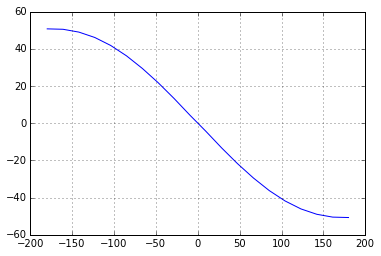

In [6]:
ras = np.linspace(-180, 180, 20)
errs = [get_att_err(att_final=(ra, 0, 0), bias_err=(100, 0, 0), step=30)[1]
       for ra in ras]
plt.plot(ras, errs)
plt.grid();

## Day 2016:324 NSM
```
ObsID Target              Start     Time   SI   Grat    RA       Dec    Roll   Pitch   Slew
-------------------------------------------------------------------------------------------
19846 HZ43   2016:324:11:48:20.079   2.0  HRC-I LETG 199.0834  29.0806  39.79  59.77 115.31
19942 Ae Aur 2016:324:12:58:16.839  29.0 ACIS-I NONE  79.1156  34.2873 121.98 154.15  95.01
```

In [7]:
att_init = 199.0834, 29.0806, 39.79
att_final = 79.1156, 34.2873, 121.98

In [8]:
dq_arcsec = (-50.081543712826715, -127.38228683796987, 113.8941879330622)  # roll, pitch, yaw

In [9]:
get_att_err(att_init, att_final, bias_err=(-115, 123, 91), verbose=True);

[-0.11937123  0.12767532  0.09445898]
roll_err=-50.52"  pitch_err=-127.15"  yaw_err=113.41"
